# Removing noise from Kepler, K2, and TESS light curves using Cotrending Basis Vectors (`CBVCorrector`)

Cotrending Basis Vectors (CBVs) are generated in the PDC component of the Kepler/K2/TESS pipeline and are used to remove systematic trends in light curves. They are built from the most common systematic trends observed in each PDC Unit of Work (Quarter for Kepler, Campaign for K2 and Sector for TESS). Each Kepler and K2 module output and each TESS CCD has its own set of CBVs. You can read an introduction to the CBVs in [Demystifying Kepler Data](https://arxiv.org/pdf/1207.3093.pdf) or to greater detail in the [Kepler Data Processing Handbook](https://archive.stsci.edu/kepler/manuals/KSCI-19081-003-KDPH.pdf). The same basic method to generate CBVs is used for all three missions.

This tutorial provides examples of how to utilize the various CBVs to clean lightcurves of common trends experienced by all targets. The technique exploits two goodness metrics that characterize the performance of the fit. [CBVCorrector](https://docs.lightkurve.org/reference/api/lightkurve.correctors.CBVCorrector.html) inherits the [RegressionCorrector](https://docs.lightkurve.org/reference/api/lightkurve.correctors.RegressionCorrector.html?highlight=regressioncorrector) class in LightKurve. It is recommend to first read the tutorial on [obtaining the CBVs](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-2-how-to-use-cbvs.html)  before reading this tutorial.

## Cotrending Basis Vector Types

There are three basic types of CBVs: 

- **Single-Scale** contains all systematic trends combined in a single set of basis vectors. 

- **Multi-Scale** contains systematic trends in specific wavelet-based band passes. There are usually three sets of multi-scale basis vectors in three bands.

- **Spike** contains only short impulsive spike systematics.

There are two different correction methods in PDC: Single-Scale and Multi-Scale. Single-Scale performs the correction in a single bandpass. Multi-Scale performs the correction in three separate wavelet-based bandpasses. Both corrections are performed in PDC but we can only export a single PDC light curve for each target. So, PDC must choose which of the two to export on a per-target basis. Generally speaking, single-scale performs better at preserving longer period signals. But at periods close to transiting planet durations multi-scale performs better at preserving signals. PDC therefore mostly chooses multi-scale for use within the planet finding pipeline and for the archive. You can find in the light curve FITS header which PDC method was chosen (keyword “PDCMETHD”). Additionally, a seperate correction is alway performed to remove short impulsive systematic spikes.

For an individual's research needs, the mission supplied PDC lightcurves might not be ideal and so the CBVs are provided to the user to perform their own correction. All three CBV types are provided at MAST for TESS, however only Single-Scale is provided at MAST for Kepler and K2. Also for Kepler and K2, Cotrending Basis Vectors are supplied for only the 30-minute target cadence.

## Obtaining the CBVs

One can directly obtain the CBVs with `load_tess_cbvs` and `load_kepler_cbvs`, either from MAST by default or from a local directory `cbv_dir`. However when generating a [CBVCorrector](https://docs.lightkurve.org/reference/api/lightkurve.correctors.CBVCorrector.html?highlight=cbvcorrector) object the appropriate CBVs are automatically downloaded from MAST and aligned to the lightcurve. Let's generate this object for a particularily interesting TESS variable target. We first download the SAP lightcurve.

In [1]:
from lightkurve import search_lightcurve
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

lc = search_lightcurve('TIC 99180739', author='SPOC', sector=10).download(flux_column='sap_flux')

Next, we create a `CBVCorrector` object. This will download the CBVs appropriate for this target and store them in the `CBVCorrector` object. In the case of TESS, this means the CBVs associated with the CCD this target is on and for Sector 10.

In [2]:
from lightkurve.correctors import CBVCorrector
cbvCorrector = CBVCorrector(lc)

Let's look at the CBVs downloaded.

In [3]:
cbvCorrector.cbvs

[TESS CBVs, Sector.Camera.CCD : 10.1.1, CBVType : SingleScale, nCBVS : 16,
 TESS CBVs, Sector.Camera.CCD : 10.1.1, CBVType.Band: MultiScale.1, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 10.1.1, CBVType.Band: MultiScale.2, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 10.1.1, CBVType.Band: MultiScale.3, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 10.1.1, CBVType : Spike, nCBVS : 6]

We see that there are a total of 5 sets of CBVs, all associated with TESS Sector 10, Camera 1 and CCD 1. The number of CBVs per type is also given. Let's plot the Single-Scale CBVs, which contain all systematics combined.

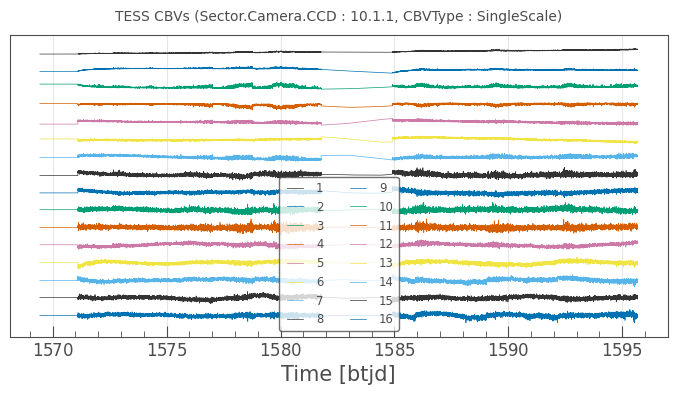

In [4]:
cbvCorrector.cbvs[0].plot();

The first several CBVs contain most of the systematics. The latter CBVs pose a greater risk of injecting more noise than helping. The default behavior in CBVCorrector is to use the first 8 CBVs.

## Assessing Over- and Under-Fitting with the Goodness Metrics

Two very common issues when fitting a model to a data set it over-fitting and under-fitting. 

Over-fitting occurs when the model has too many degrees of freedom and fits the data  _at all costs_, instead of just modelling the physical process it is attempting to model. This can exhibit itself in different ways, depending on the system and application. In the case of fitting systematic trend basis vectors to a time series, over-fitting can result in the basis vectors removing intrinsic signals in the times series instead of just the systematics. It can also result in introduced broad-band noise. This can be particularily prominant in an unconstrained least-squares fit. A least-squares fit only cares about minimizing it's loss function, which is the Root Mean Square error. In the course of minimizing the RMS, narrow-band power representing the systematic trends are exchanged for broad-band noise intrinsic in the basis vectors. This results in the overall RMS decreasing but the noise in the time series increasing, resulting in the obscuration of the signals under interest. A very common method to inhibit over-fitting is to introduce a regularization term in the loss function. This constrains the fit and effectively reduces the degrees of freedom.

Under-fitting occurs when the model has too few degrees of freedom and fails to adequately model the physical process it is attempting to model. In the case of fitting systematic trend basis vectors to a time series, under-fitting can result in residual systematics. Under-fitting can either be the result of the basis vectors not adequately representing the systematics or, placing too great of a restriction on the model during fitting. The regularization technique used to inhibit over-fitting can therefore result in under-fitting. The ideal fit will balance the counter-acting phenomena of over- and under-fitting. To this end, a method can be developed to measure the degree to which these two phenomena occur.

PDC has two **Goodness Metrics** to assess over- and under-fitting:

- **Over-fitting metric**: Measures the introduced noise in the light curve after the correction. It does so by measuring the broad-band power spectrum via a Lomb-Scargle Periodogram both before and after the correction. If power has increased after the correction then this is an indication the CBV fit has over-fitted and introduced noise. The metric treats all frequencies equally when measuring power increase; from one frequency separation to the Nyquist frequency. This metric is callibrated such that a metric value of 0.5 means the introduced noise due to over-fitting is at the same power level as the uncertainties in the light curve.

- **Under-fitting metric**: Measures the mean residual target to target Pearson correlation between the target under study and a selection of neighboring targets. This metric will find and download a selection of neighboring SPOC SAP targets in RA and Decl. until a minimum number is found. The metric is callibrated such that a value of 0.95 means the residual correlations in the target is equivalent to chance correlations of White Gaussian Noise.

_The Goodness Metrics are not perfect!_ They are an estimate of over- and under-fitting and are to be used as a guideline along other other metrics to assess the quality of your light curve.

The Goodness Metrics are part of the `lightkurve.correctors.metrics` module and can be computed directly with calls to `overfit_metric_lombscargle` and `underfit_metric_neighbors`. The 'CBVCorrector' has convenience wrappers for the two metrics and so they do not need to be called directly, as we will show below.

## Example Correction with CBVCorrector to Inhibit Over-Fitting

There are four correction methods within `CBVCorrector`:

- **correct**: Performs a numerical correction using the LightKurve [RegressionCorrector.correct](https://docs.lightkurve.org/reference/api/lightkurve.correctors.RegressionCorrector.correct.html?highlight=regressioncorrector%20correct#lightkurve.correctors.RegressionCorrector.correct) method while optimizing the L2-Norm regularization penalty term using the goodness metrics as the Loss Function.

- **correct_gaussian_prior**: Performs an analytical correction using the LightKurve [RegressionCorrector.correct](https://docs.lightkurve.org/reference/api/lightkurve.correctors.RegressionCorrector.correct.html?highlight=regressioncorrector%20correct#lightkurve.correctors.RegressionCorrector.correct) method while setting the L2-Norm (Ridge Regression) regularization penalty term as the Gaussian prior.

- **correct_elasticnet**:  Performs the correction using Scikit-Learn's [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), which combines both an L1- and L2-Norm regularization.

- **correct_regressioncorrector**: Performs the standard [RegressionCorrector.correct](https://docs.lightkurve.org/reference/api/lightkurve.correctors.RegressionCorrector.correct.html?highlight=regressioncorrector%20correct#lightkurve.correctors.RegressionCorrector.correct) correction. RegressionCorrector is the superclass to CBVCorrector and this is a "passthrough" method to access the superclass `correct` method.

If you are unfamilar with L1-Norm (LASSO) and L2-Norm (Ridge Regression) regularization then there are [severel](https://www.statlearning.com/), [excellent](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy), [introductions](https://en.wikipedia.org/wiki/Regularization_(mathematics)). You can read how a L2-norm relates to a Gaussian prior in a linear design matrix in [this reference](https://katbailey.github.io/post/from-both-sides-now-the-math-of-linear-regression/).

The default method is `correct` and generally speaking, one can use just this method to obtain a good fit. The other methods are for advanced usage.

We'll start with `correct_gaussian_prior` in order to introduce the concepts. Doing so will allow us to force a very weak regularization term (alpha=1e-4) as an illustration.

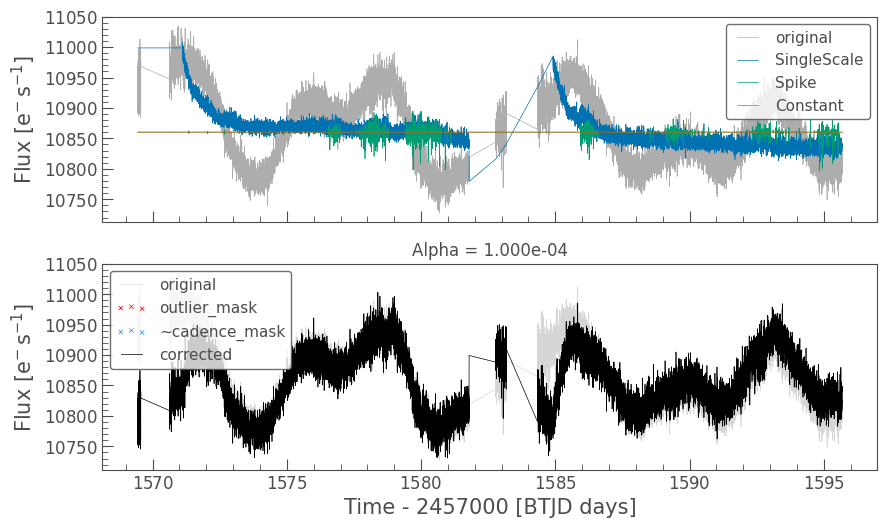

In [5]:
# Select which CBVs to use in the correction
cbv_type = ['SingleScale', 'Spike']
# Select which CBV indices to use
# Use the first 8 SingleScale and all Spike CBVS
cbv_indices = [np.arange(1,9), 'ALL']
# Perform the correction
cbvCorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, alpha=1e-4)
cbvCorrector.diagnose();

First note that CBVCorrector always fits a constant term in the model, but the constant is never subtracted in the resultant corrected flux. The median flux value of the light curve is always preserved.

At first sight, this looks like a good correction. Both the Single-Scale and Spike basis vectors are being utilized to fit out as much of the signal as possible. The corrected light curve is indeed flatter. But this was essentially an unrestricted least-squares correction and we may have _over-fitted_. The very strong lips right at the beginning of each orbit is probably a chance correlation between the star's inherent stellar variability and the thermal settling systematic that is common in Kepler and TESS lightcurves. Let's look at the CBVCorrector goodness metrics to determine if this is the case.

In [6]:
# Note: this cell will be slow to run
print('Over fitting Metric: {}'.format(cbvCorrector.over_fitting_metric()))
print('Under fitting Metric: {}'.format(cbvCorrector.under_fitting_metric()))

Over fitting Metric: 0.7701418096536327


Under fitting Metric: 0.998861504673248


The first time you run the under-fitting goodness metric it will download the SPOC SAP light curves of targets in the neighborhood around the target under study in order to estimate the residual systematics (they are stored in the CBVCorrector object for subsequent computations). A goodness metric of 0.8 or above is generally considered good. In this case, it looks like we over-fitted (over-fitting metric = 0.71). Even though the corrected light curve looks better, our metric is telling us we probably injected signals into our lightcurve and we should not trust this really nice looking curve. Perhaps we can do better if we _regularize_ the fit.

## Using the Goodness Metrics to Optimize the Fit

We will start by performing a scan of the over- and under-fit goodness metrics as a function of the L2-Norm regularization term, alpha.

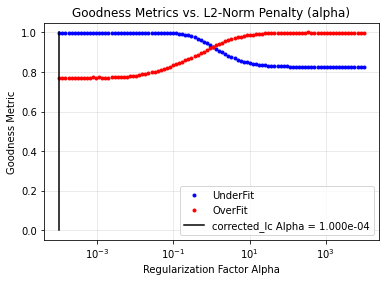

In [7]:
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

This scan also plots the last used alpha parameter as a vertical black line (alpha=1e-4 in our case). We are clearly not optimizing this fit for both over- and under-fitting. Let's use the `correct` numerical optimizer to try to optimize the fit.

Optimized Over-fitting metric: 0.9996917363019228
Optimized Under-fitting metric: 0.8256122767990377
Optimized Alpha: 9.644e+03


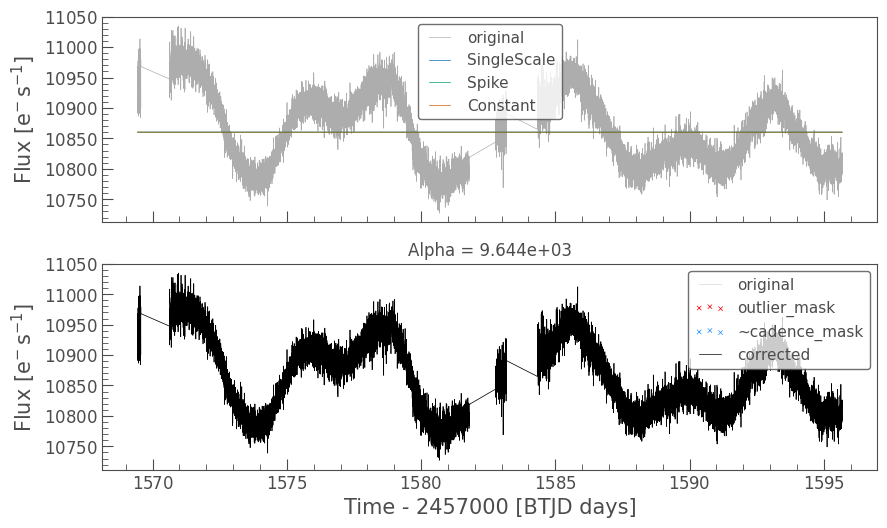

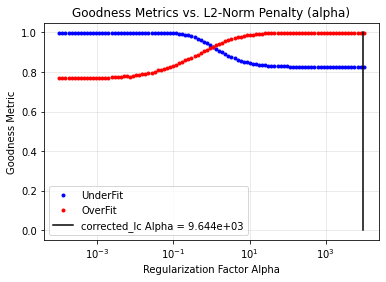

In [8]:
cbvCorrector.correct(cbv_type=cbv_type, cbv_indices=cbv_indices);
cbvCorrector.diagnose();
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

Much better! We see the thermal settling systematic is still being removed, but the stellar variabity is better preserved. Note that the optimizer did not set the alpha parameter at exactly the red and blue curve intersection point. The default target goodness scores is 0.8 or above, which is fulfilled at alpha=1.45e-1. If we want to optimize the fit even more, by perhaps ensuring we are not over-fitting at all, then we can adjust the target over and under scores to emphasize which metric we are more interested in. Below we more greatly emphasize improving the over-fitting metric by setting the target to 0.9.

Optimized Over-fitting metric: 0.9996935525791087
Optimized Under-fitting metric: 0.8256120264211814
Optimized Alpha: 9.868e+03


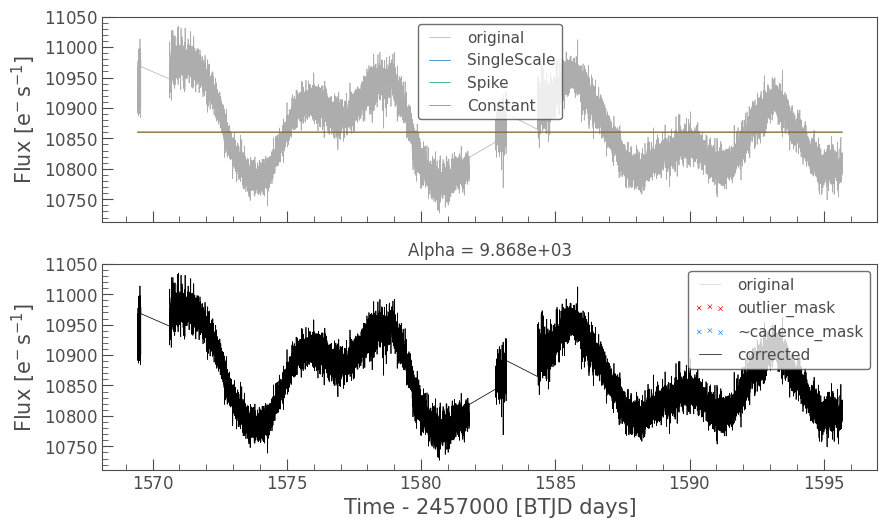

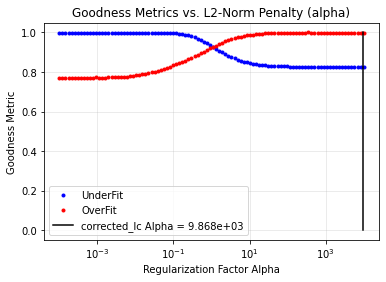

In [9]:
cbvCorrector.correct(cbv_type=cbv_type,
                     cbv_indices=cbv_indices, 
                     target_over_score=0.9,
                     target_under_score=0.5)
cbvCorrector.diagnose();
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

We are now perhaps biasing too far towards under-fitting, but depending on your research interests, this might be best.

## No Single Best Answer Example

Let's now look at another example, this time where there is no clear single best answer. Again, we will use the Single-Scale and Spike basis vectors for the correction and begin with low regularization.

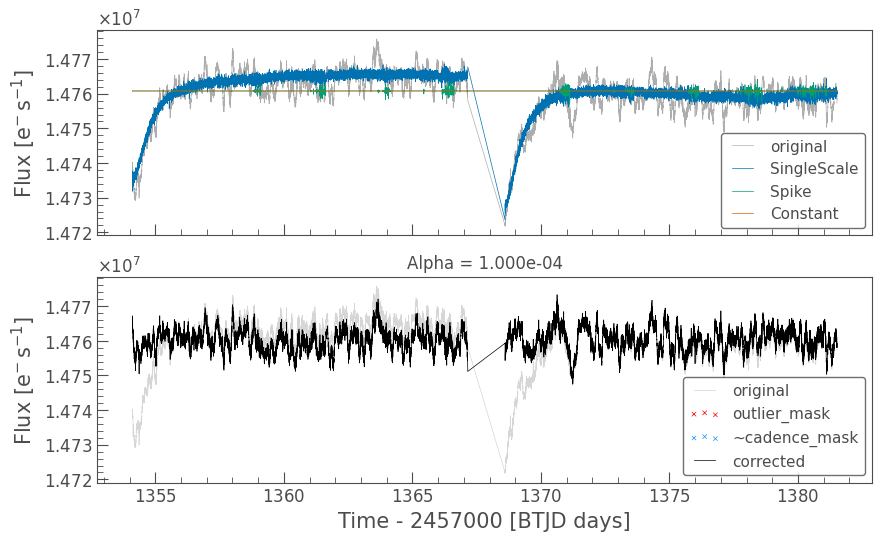

In [10]:
lc = search_lightcurve('TIC 38574307', author='SPOC', sector=2).download(flux_column='sap_flux')
cbvCorrector = CBVCorrector(lc)
cbv_type = ['SingleScale', 'Spike']
cbv_indices = [np.arange(1,9), 'ALL']
cbvCorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, alpha=1e-4)
cbvCorrector.diagnose();

At first sight, this looks good. The long term trends have been removed and the periodic noisy bits have been removed with the spike basis vectors. But did we really do a good job?

Over fitting Metric: 0.36932896005261673


Under fitting Metric: 0.9998238120367


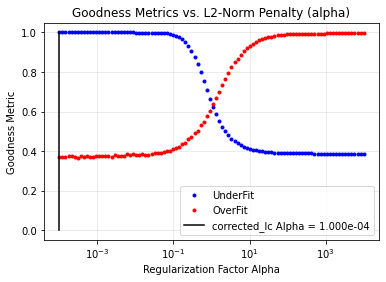

In [11]:
print('Over fitting Metric: {}'.format(cbvCorrector.over_fitting_metric()))
print('Under fitting Metric: {}'.format(cbvCorrector.under_fitting_metric()))
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

Hmm... The over-fitting goodness metric says we are severely over-fitting. Not only that, there appears to not be an Alpha parameter that brings both goodness metrics above 0.8. And yet, the fit looks really good. What's going on here? Let's zoom in on the correction.

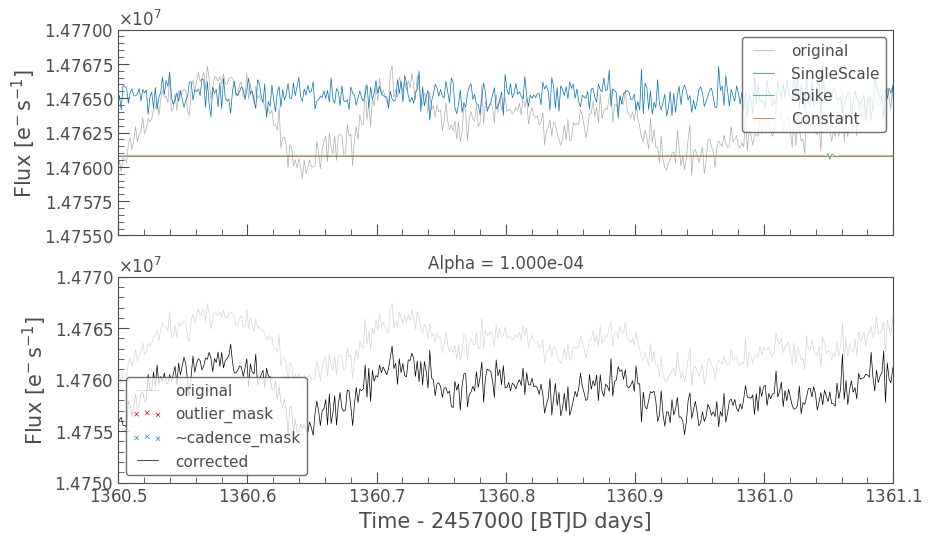

In [12]:
pltAxis = cbvCorrector.diagnose()
pltAxis[0].set_xlim(1360.5, 1361.1)
pltAxis[0].set_ylim(1.4755e7, 1.477e7);
pltAxis[1].set_xlim(1360.5, 1361.1)
pltAxis[1].set_ylim(1.475e7, 1.477e7);

We see in the top plot that the _SingleScale_ correction has comperable noise to the _original_ light curve. This means the correction is injecting high frequency noise at comperable amplitude to the original signal. We have indeed over-fitted! The goodness metrics perform a _broad-band_ analysis of over- and under-fitting. Even though our eyes did not see the high frequency noise injection, the goodness metrics did. So, what should be done? It depends on what you are trying to investigate. If you are only looking at the low frequency signals in the data then perhaps you don't care about the high frequency noise injection. If you really do care about the high frequency signals then you should increase the Alpha parameter, or set the target goodness scores as we do below (target_over_score=0.8, target_under_score=0.5). 

Optimized Over-fitting metric: 0.7990421976783335
Optimized Under-fitting metric: 0.477464493315342
Optimized Alpha: 2.823e+00


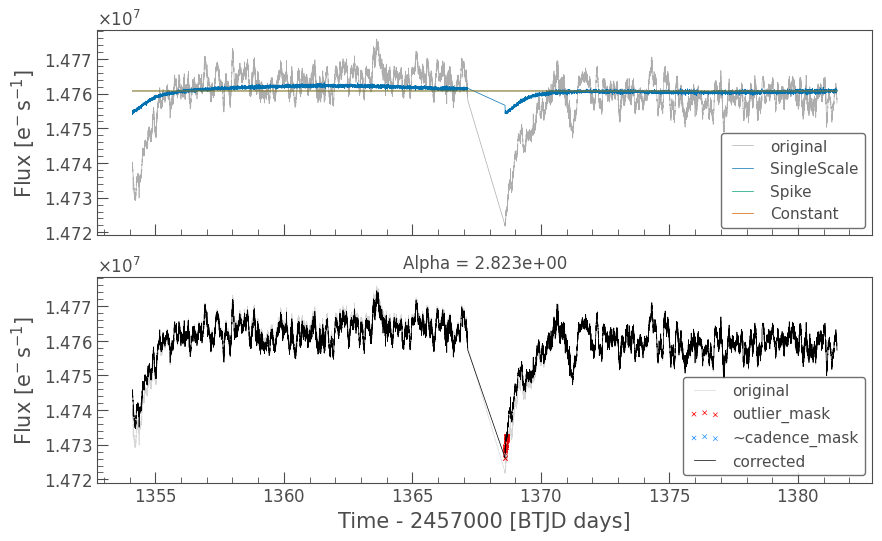

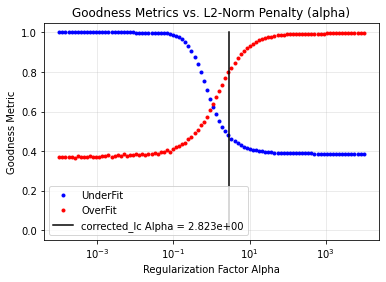

In [13]:
# Optimize the fit but overemphasize the importance of not over-fitting.
cbvCorrector.correct(cbv_type=cbv_type,
                     cbv_indices=cbv_indices, 
                     target_over_score=0.8,
                     target_under_score=0.5)
cbvCorrector.diagnose()
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

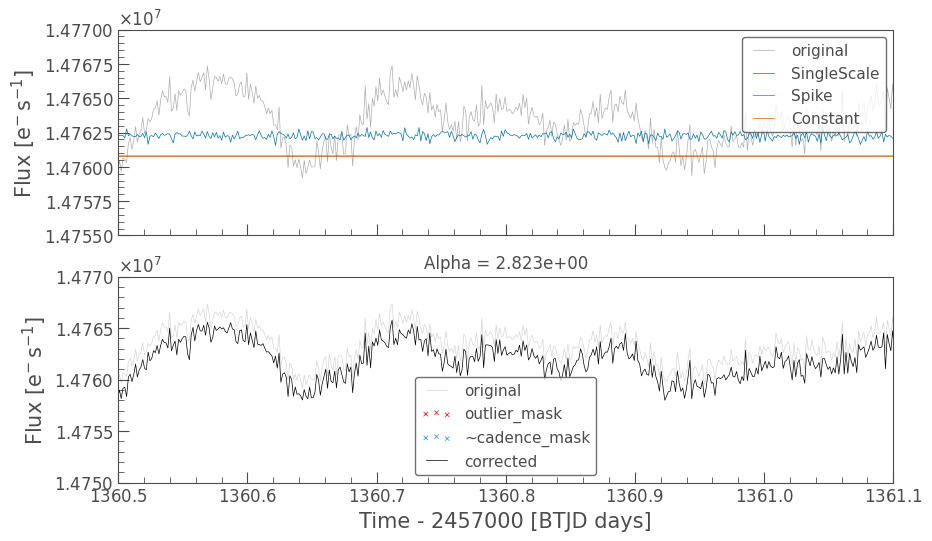

In [14]:
# Again, zoom in to see the detail
pltAxis = cbvCorrector.diagnose()
pltAxis[0].set_xlim(1360.5, 1361.1)
pltAxis[0].set_ylim(1.4755e7, 1.477e7);
pltAxis[1].set_xlim(1360.5, 1361.1)
pltAxis[1].set_ylim(1.475e7, 1.477e7);

We see now that the high frequency noise injection is small compared to the original amplitudes in the lightkurve. We barely removed any of the systematics and are now under-fitting, but that might be the best we can do if we want to ensure low noise injection.

## ...Or Can We Still Do Better?

Perhaps we are using the incorrect CBVs for this target. Below is a tuned multi-step fit where we first fit the multi-scale Band 2 CBVs then the Spike CBVs. The multi-scale band 2 CBVs contain intermediate frequency systematic signals. They should not inject high frequency noise. We also utilize the `correct_elasticnet` corrector, which allows us to add in a L1-Norm term (Lasso Regularization). L1-Norm helps snap some basis vector fit coefficients to zero and can result in a more stable, less noisy fit. The result is a much better compromise between over- and under-fitting. The spikes are not well removed but increasing the weight on the Spike CBV removal results in over-fitting. We can also try the multi-scale band 3 CBVs, which contain high frequency systematics, but the over-fitting metric indicates using them results in even greater over-fitting. The resultant is now much better than what we achieved above but more tuning and optimization could possibly get us even closer to an ideal fit.

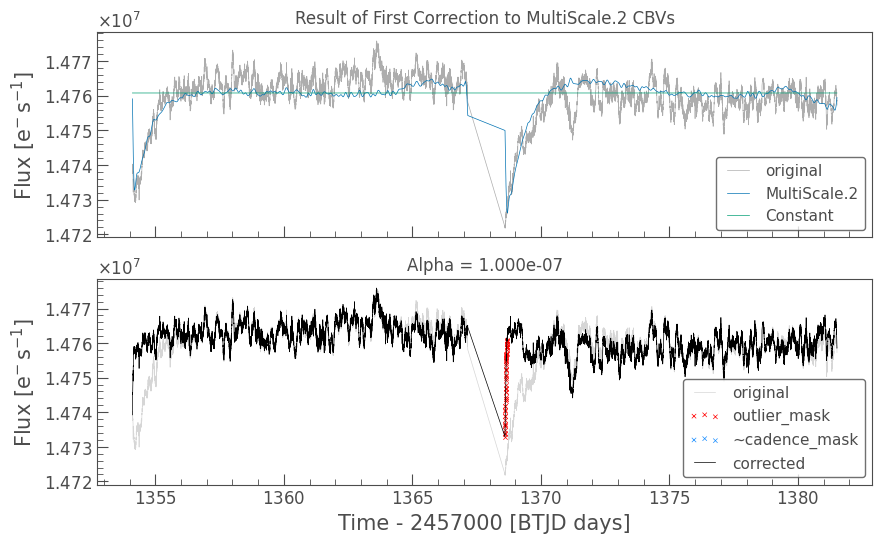

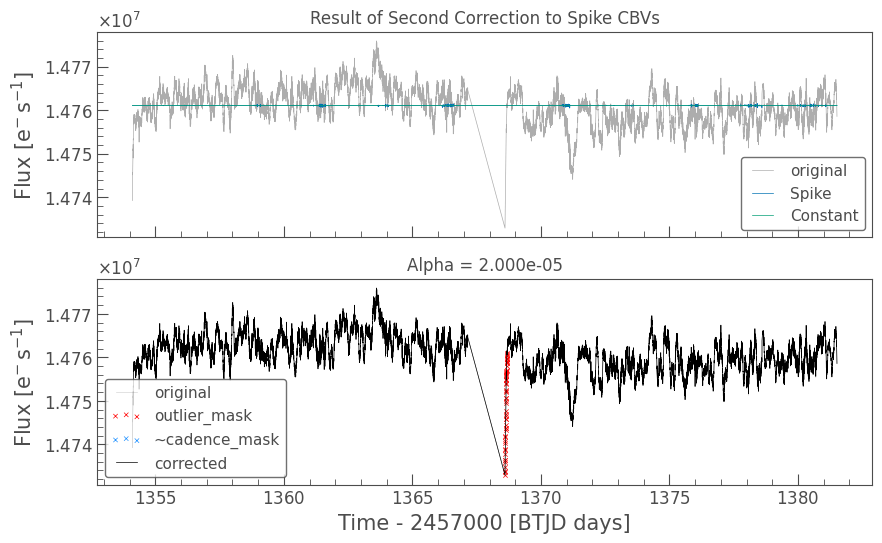

In [15]:
# Fit to the Multi-Scale Band 2 CBVs with ElasticNet to add in a L1-Norm (Lasso) term
cbvCorrector.correct_elasticnet(cbv_type=['MultiScale.2'], cbv_indices=[np.arange(1,9)], alpha=1.0e-7, l1_ratio=0.5)
ax = cbvCorrector.diagnose()
ax[0].set_title('Result of First Correction to MultiScale.2 CBVs');

# Set the corrected LC as the initial LC in a new CBVCorrector object before moving to the next correction.
# You could instead just reassign to the first cbvCorrector object, if you do not wish to save the original.
cbvCorrectorIter2 = cbvCorrector.copy()
cbvCorrectorIter2.lc = cbvCorrectorIter2.corrected_lc.copy()

# Fit to the Spike Basis Vectors, using an L1-Norm term.
cbvCorrectorIter2.correct_elasticnet(cbv_type=['Spike'], cbv_indices=['ALL'], alpha=2.0e-5, l1_ratio=0.7)
ax = cbvCorrectorIter2.diagnose()
ax[0].set_title('Result of Second Correction to Spike CBVs');

Over-fitting Metric: 0.6734063377708963
Under-fitting Metric: 0.8283914619415863


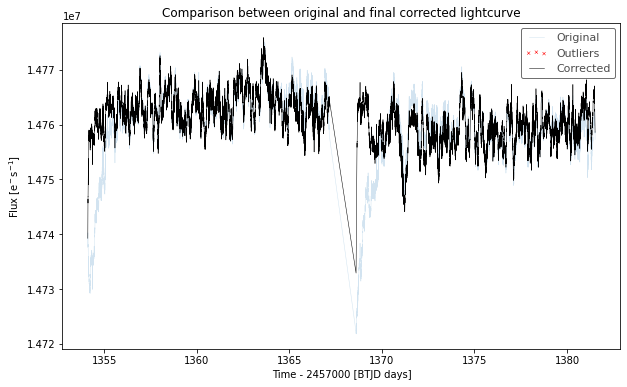

In [16]:
# Compute the final goodness metrics compared to the original lightcurve.
# This requires us to copy the original light curve into cbvCorrectorIter2.lc so that the goodness metrics compares the corrected_lc to the proper initial light curve.
cbvCorrectorIter2.lc = cbvCorrector.lc.copy()
print('Over-fitting Metric: {}'.format(cbvCorrectorIter2.over_fitting_metric()))
print('Under-fitting Metric: {}'.format(cbvCorrectorIter2.under_fitting_metric()))

# Plot the final correction
_, ax = plt.subplots(1, figsize=(10, 6))
cbvCorrectorIter2.lc.plot(ax=ax, normalize=False, alpha=0.2, label='Original')
cbvCorrectorIter2.corrected_lc[~cbvCorrectorIter2.cadence_mask].scatter(
                                            normalize=False, c='r', marker='x',
                                            s=10, label='Outliers', ax=ax)
cbvCorrectorIter2.corrected_lc.plot(normalize=False, label='Corrected', ax=ax, c='k')
ax.set_title('Comparison between original and final corrected lightcurve');

So, which CBVs are best to use? There is no one single answer, but generally speaking, the Multi-Scale Basis vectors are more versatile. The trade-off is there are also more of them, which means more degrees of freedom in your fit. More degrees of freedom can result in more over-fitting without proper regularization. It is recommened the user tries different combinations of CBVs and use objective metrics to decide which fit is the best for their particular needs.

## Using the Goodness Metrics and CBVCorrector with other Design Matrices

The Goodness Metrics and CBVCorrector can also be used in conjunction with other external design matrices. Let's work on a famous planet example to show how the CBVCorrector can be utilized to imporove the generated light curve. We will begin by using [search_tesscut](https://docs.lightkurve.org/reference/api/lightkurve.search_tesscut.html?highlight=search_tesscut) to extract an FFI light curve for HAT-P 11 and then create a DesignMatrix using the background pixels.

In [17]:
# HAT-P 11b
from lightkurve import search_tesscut
from lightkurve.correctors import DesignMatrix
search_result = search_tesscut('HAT-P-11', sector=14)
tpf = search_result.download(cutout_size=20)
# Create a simple thresholded aperture mask
aper = tpf.create_threshold_mask(threshold=15, reference_pixel='center')
# Generate a simple aperture photometry light curve
raw_lc = tpf.to_lightcurve(aperture_mask=aper)
# Create a design matrix using PCA components from the cutout background
dm = DesignMatrix(tpf.flux[:, ~aper], name='pixel regressors').pca(5).append_constant()

The [DesignMatrix](https://docs.lightkurve.org/reference/api/lightkurve.correctors.DesignMatrix.html?highlight=designmatrix#lightkurve.correctors.DesignMatrix) `dm` now contains the common trends in the background pixels in the data. We will first try to fit the pixel-based design matrix using an unrestricted least-squares fit (I.e. a very weak regularization by setting alpha to a small number). We tell CBVCorrector to only use the external design matrix with `ext_dm=`. When we generate the CBVCorrector object the CBVs will be downloaded, but the CBVs are for 2-minute cadence and not the 30-minute FFIs. We therefore use the `interpolate_cbvs=True` option to tell the CBVCorrector to interpolate the CBVs to the light curve cadence.

Over-fitting metric: 0.07928911035289435
CDPP: 230.75800274217823 ppm


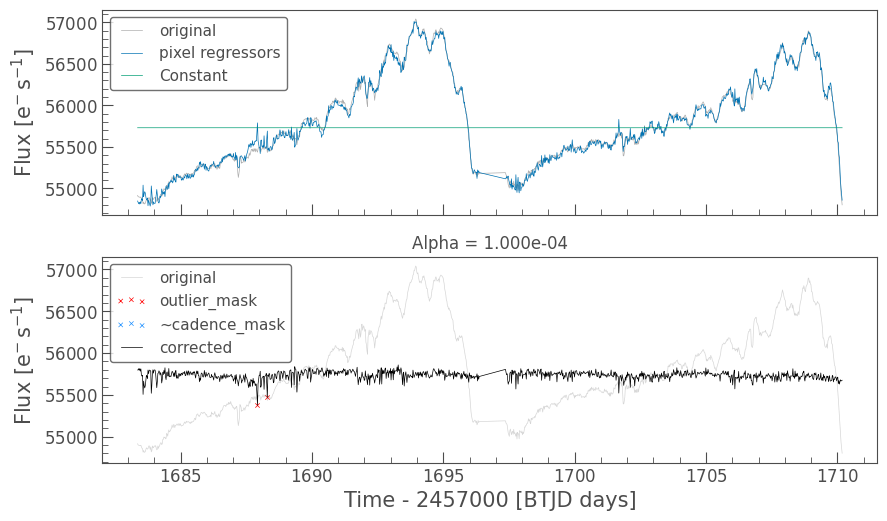

In [18]:
# Generate the CBVCorrector object and interpolate the downloaded CBVs to the light curve cadence
cbvcorrector = CBVCorrector(raw_lc, interpolate_cbvs=True)
# Perform an unrestricted least-squares fit using only the pixel-derived design matrix.
cbvcorrector.correct_gaussian_prior(cbv_type=None, cbv_indices=None, ext_dm=dm, alpha=1e-4)
cbvcorrector.diagnose()
print('Over-fitting metric: {}'.format(cbvcorrector.over_fitting_metric()))
print('CDPP: {}'.format(cbvcorrector.corrected_lc.estimate_cdpp()))
corrected_lc_just_pixel_dm = cbvcorrector.corrected_lc

The least-squares fit did remove the background flux trend and at first sight the resultant might look good, but the over-fitting goodness metric is `0.08`. That's not very good! It looks like we are dramatically over-fitting. We can see this in the bottom plot where the corrected curve has more high-frequency noise than the original. Let's now add in the multi-scale basis vectors and see if we can do better. Note that we are joint fitting the CBVs and the external pixel-derived design matrix.

Over-fitting metric: 0.31542380309201745
CDPP: 55.83742644002937 ppm


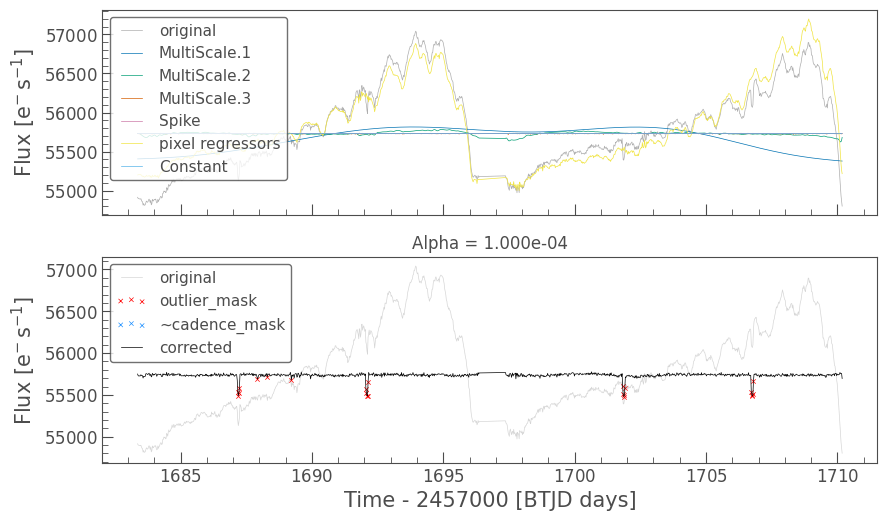

In [19]:
cbv_type = ['MultiScale.1', 'MultiScale.2', 'MultiScale.3','Spike']
cbv_indices = [np.arange(1,9), np.arange(1,9), np.arange(1,9), 'ALL']
cbvcorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, ext_dm=dm, alpha=1e-4)
cbvcorrector.diagnose()
print('Over-fitting metric: {}'.format(cbvcorrector.over_fitting_metric()))
print('CDPP: {}'.format(cbvcorrector.corrected_lc.estimate_cdpp()))
corrected_lc_joint_fit = cbvcorrector.corrected_lc

That looks a lot better! Could we do a bit better by adding in a regularization term? Let's do a goodness metric scan.

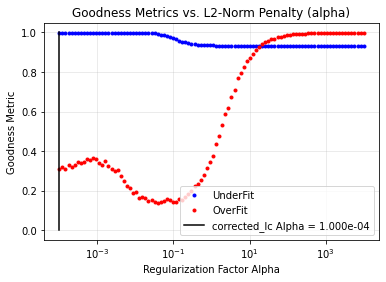

In [20]:
cbvcorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices, ext_dm=dm);

There are a couple observations to make here. 

First, the under-fitting metric has a very good score throughout the regularization scan. This is because the under-fitting metric compares the corrected light curve to neighboring targets in RA and Decl. that are archived as 2-minute SAP-flux targets. _The SAP flux already has the background removed_ so the neighoring targets do not contain the very large background trends. The under-fitting metric is therefore not very helpful. In the next run we will disable the under-fitting metric in the optimization (by setting target_under_score=-1).

We see the over-fitting metric is not a simple function of the regularization factor _alpha_. This can happen due to the interaction of the various basis vectors during fitting when regularization is applied. We see a minima (most over-fitting) at about alpha=1e-1. Once alpha moves above this value we begin to over-constrain the fit which results in gradually less removal of systematics. The under-fitting metric should be an indicator that we are going too far constraining the fit, and indeed, we do see the under-fitting metric degrades slightly beginning at alpha=1e-1.

We will now try to optimize the fit and account for these two issues by 1) setting the bounds on the alpha parameter (`alpha_bounds=[1e-6, 1e-2]`) and 2) disregarding the under-fitting metric (`target_under_score=-1`).

Optimized Over-fitting metric: 0.3502847809074801
Optimized Alpha: 8.784e-04
CDPP: 68.51886968421978 ppm


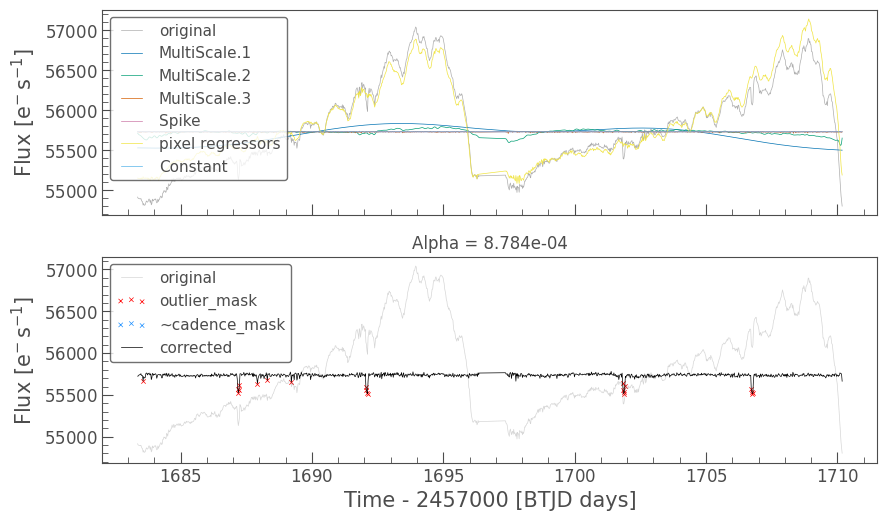

In [21]:
# Optimize the fit but ignore the under-fitting metric and set bounds on the alpha parameter.
cbvcorrector.correct(cbv_type=cbv_type, cbv_indices=cbv_indices, ext_dm=dm, alpha_bounds=[1e-6, 1e-2], target_over_score=0.8, target_under_score=-1)
cbvcorrector.diagnose();
print('CDPP: {}'.format(cbvcorrector.corrected_lc.estimate_cdpp()))

This is looking like a pretty good light curve. However, the CDPP increased a little as we optimized the over-fitting metric. Which correction to use may depend on your application. Since we are interested in the transiting planet, we will choose the corrected light curve with the lowest CDPP. Below we compare the light curve between just using the pixel-derived design matrix to also adding in the CBVs as a joint, regularized  fit.

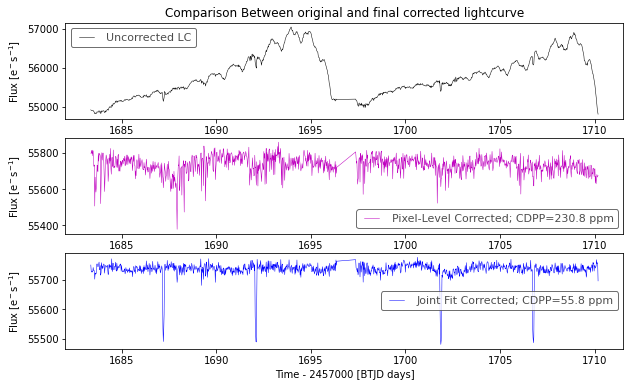

In [22]:
_, ax = plt.subplots(3, figsize=(10, 6))
cbvcorrector.lc.plot(ax=ax[0], normalize=False, label='Uncorrected LC', c='k')
corrected_lc_just_pixel_dm.plot(normalize=False, label='Pixel-Level Corrected; CDPP={0:.1f}'.format(corrected_lc_just_pixel_dm.estimate_cdpp()), ax=ax[1], c='m')
corrected_lc_joint_fit.plot(normalize=False, label='Joint Fit Corrected; CDPP={0:.1f}'.format(corrected_lc_joint_fit.estimate_cdpp()), ax=ax[2], c='b')
ax[0].set_title('Comparison Between original and final corrected lightcurve');

The superiority of the bottom curve is blatantly obvious. We can clearly see HAT-P 11b on it's 4.9 day period orbit. Our over-fitting metric settled at about 0.35 indicating we might still be over-fitting and should keep that in mind. However the low CDPP indicates the over-fitting is probably not over transit time-scales. 

## Some final comments on CBVCorrector

### Application to Kepler vs K2 vs TESS

CBVCorrector works equally across Kepler, K2 and TESS. However the Multi-Scale and Spike basis vectors are only available for TESS[<sup>1</sup>](#fn1). For K2, the [PLDCorrector](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-k2-pldcorrector.html) and [SFFCorrector](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-k2-sffcorrector.html) classes might work better than `CBVCorrector`.

If you want to just get the CBVs but not generate a CBVCorrector object then use the functions _load_kepler_cbvs_ and _load_tess_cbvs_ within the cbvcorrector module as explained [here](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-2-how-to-use-cbvs.html).

<sup>1</sup><span id="fn1"> Unfortunately, the Multi-Scale and Spike CBVs are not archived at MAST for Kepler/K2.</span>

### Applicability of the Over- and Under-fitting Goodness Metrics

The under-fitting metric computes the correlation between the corrected light curve and a selection of neighboring SPOC SAP light curves. If the light curve you are trying to correct was not generated by the SPOC pipeline (I.e. not a SAP light curve), then the neighboring SAP light curves might not contain the same instrumental systematics and the under-fitting metric might not properly measure when under-fitting is occuring. 

The over-fitting metric examines the periodogram of the light curve before and after the correction and is therefore indifferent to how the light curve was generated. It simply looks to see if noise was injected into the light curve. The over-fitting metric is therefore much more generally applicable.

The Goodness Metrics are part of the `lightkurve.correctors.metrics` module and can be computed directly with calls to `overfit_metric_lombscargle` and `underfit_metric_neighbors`. A savvy expert user can use these and other quality metrics to generate their own Loss Function for optimizing a fit.

### Aligning versus Interpolating CBVs

By default, all loaded CBVS in `CBVCorrector` are "aligned" to the light curve cadence numbers (`CBVCorrector.lc.cadenceno`). This means only cadence numbers that exist in both the CBVs and the light curve will have values in the returned CBVs. All cadence numbers that exist in the light curve but not in the CBVs will have NaNs returned for the CBVs on those cadences and the Gap Indicator set to True. Any cadences in the CBVs not in the light curve will be removed from the CBVs.


If the light curve cadences do not overlap well with the CBVs then you can set `interpolate_cbvs=True` when generating the `CBVCorrector` object. Doing so will generate interpolated CBV values for all cadences in the light curve. If the light curve has cadences past either end of the cadences in the CBVs then one must extrapolate. A second argument, `extrapolate_cbvs`, can be used to also extrapolate the CBV values to the light curve cadences. If `extrapolate_cbvs=False` then the exterior values are set to NaNs, which will probably result is a very poor fit.

**Warning**: *The safest method is to align*. This will not generate any new values for the CBVs. Interpolation can be potentially dangerous. Interpolation uses Piecewise Cubic Hermite Interpolating Polynomial (PCHIP), which can be more stable than a simple spline, but no interpolation method works in all situations. Extrapolation is even more dangerious, which is why an extra parameter must be set if one desires to extrapolate. *Be sure to manually examine the extrapolated CBVs before use!*

### Joint Fitting

By including the `ext_dm=` parameter in the `correct_*` methods we allow for joint fitting between the CBVs and other design matrices. Generally speaking, if fitting a collection of different models to a system, joint fitting is ideal. For example, if performing transit analysis one could add in a transit model to the joint fit to get the best transit recovery. The fit coefficient to the transit model is stored in the `CBVCorrector` object after fitting and can be recovered.

### Hyperparameter Optimization

Any model fitting should include a hyperparameter optimization step. The `correct_optimizer` is essentially a 1-dimensional optimizer and is very fast. More advanced hypterparameter optimization can be performed by tuning the `alpha` and `l1_ratio` parameters in `correct_elasticnet` plus the number and type of CBVs, along with an external design matrix. The optimization Loss Function can use a combination of the `under_fitting_metric`, `over_fitting_metric` and `lc.estimate_cdpp` methods. Writing such an optimzer is left as an exercise to the reader and to be tuned to the reader's particular application.

### More Generalized Design Matrix Priors

The main [CBVCorrector.correct*](https://docs.lightkurve.org/reference/api/lightkurve.correctors.CBVCorrector.html?highlight=cbvcorrector%20correc#lightkurve.correctors.CBVCorrector) methods utilize a similar prior for all design matrix vectors as is typically used in L1-Norm and L2-Norm regularization. However you can perform fine tuning to the correction using more sophisticated priors. After performing a fit with one of the `CBVCorrector.correct*` methods, `CBVCorrector.design_matrix_collection` will have the priors set. One can then manually adjust the priors and use `CBVCorrector.correct_regressioncorrector` to perform the standard [RegressionCorrector.correct](https://docs.lightkurve.org/reference/api/lightkurve.correctors.RegressionCorrector.correct.html?highlight=regressioncorrector%20correct#lightkurve.correctors.RegressionCorrector.correct) correction. An illustration is below:

In [23]:
# 1) Perform an initial optimization with a L2-Norm regularization
# cbvCorrector.correct(cbv_type=cbv_type, cbv_indices=cbv_indices);

# 2) Examine the quality of the resultant lightcurve in cbvcorrector.corrected_lc
# Determine how to adjust the priors and make changes to the design matrix
# cbvCorrector.design_matrix_collection[i].prior_sigma[j] = # ... adjust the priors

# 3) Call the superclass correct method with the adjusted design_matrix_collection
# cbvCorrector.correct_regressioncorrector(cbvCorrector.design_matrix_collection, **kwargs)

The `cbvCorrector.corrected_lc` will now be the result of the fit using whatever `cbvCorrector.design_matrix_collection` you had just provided.

### NaNs, Units and Normalization

NaNs are removed from the light curve when used to generate the `CBVCorrector` object and is stored in `CBVCorrector.lc`. 

The CBVCorrector performs its corrections in absolute flux units (typically electrons per second). The returned corrected light curve `corrected_lc` is also in absolute units and the median flux of the light curve is preserved.

In [24]:
print('LC unit: {}'.format(cbvCorrector.lc.flux.unit))
print('Corrected LC unit: {}'.format(cbvCorrector.corrected_lc.flux.unit))

LC unit: electron / s
Corrected LC unit: electron / s


The goodness metrics are computed using median normalized units in order to properly calibrate the metric to be between 0.0 and 1.0 for all light curves. The normalization is as follows:

In [25]:
normalized_lc = cbvCorrector.lc.normalize()
normalized_lc -= 1.0
print('Normalized Light curve units: {} (i.e astropy.units.dimensionless_unscaled)'.format(normalized_lc.flux.unit))

Normalized Light curve units:  (i.e astropy.units.dimensionless_unscaled)
